# Transformer model for language understanding

FYP: Machine translation models for Cantonese-English pair

In [153]:
!pip install -q tfds-nightly

# Pin matplotlib version to 3.2.2 since in the latest version
# transformer.ipynb fails with the following error:
# https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
!pip install -q matplotlib==3.2.2
!pip install -q wget

!pip install -q tensorflow

In [154]:
import tensorflow_datasets as tfds
import tensorflow as tf

import re
import time
import numpy as np
import matplotlib.pyplot as plt

## Setup input pipeline

In [182]:
import pandas as pd
import glob
import os

all_csv = glob.glob(os.getcwd() + "/train.csv")  

df_test = pd.read_csv(os.getcwd() + "/test.csv", sep='\t', encoding='utf-8')  
 
df_from_each_file = (pd.read_csv(f, sep='\t', encoding='utf-8') for f in all_csv)
df = pd.concat(df_from_each_file)

# Check for null
df[df['yue'].isnull()]
df = df.dropna()
df_test = df_test.dropna()

YueChar = True
# Delete spaces between n-gram in Cantonese
# Perform Character based tokenization in Cantonese
if YueChar:
    df['yue'] = df['yue'].str.replace(r' ', '')
    df_test['yue'] = df_test['yue'].str.replace(r' ', '')

df.head()

,yue,eng
0,唔準掂同食醃菜唔準坐梳化或者屋企人嘅床上每次經期完咗要洗床單就算床單無汚糟到他們認為我唔純潔...,I was not allowed to touch or eat pickles I wa...
1,佢地扮怪面嚇人,They were making scary faces
2,唔會搞到我哋變得邪惡女人型變成自由黨人咩,turn us into godless sissy liberals
3,呢個模式可以清晰令您瞭解佢哋,So it spells those out in very clean terms
4,幾多萬億掌聲,How many trillions Applause


Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [183]:
import regex as re
def spliteKeyWord(str):
    regex = r"[\u4e00-\ufaff]|[0-9]+|[a-zA-Z]+\'*[a-z]*"
    matches = re.findall(regex, str, re.UNICODE)
    return ' '.join(matches)

if YueChar:
    df['yue'] = df['yue'].apply(lambda x: spliteKeyWord(x))
    df_test['yue'] = df_test['yue'].apply(lambda x: spliteKeyWord(x))
df_test.head()

,yue,eng
0,我 相 信 主,I believe the almighty
1,好 耐 以 嚟 有 發 展 紊 亂 嘅 小 朋 友,For too long now children with developmental d...
2,一 般 會 遇 到 兩 種 反 應,I have two kinds of reactions
3,但 再 諗 下 嗰 位 官 員 未 必 係 唯 一 睇 小 女 性 嘅 人 呢 種 偏 見 ...,But think about this The IMF official is hardl...
4,佢 將 呢 個 病 毒 傳 畀 BB,She passes that virus on to baby


### Set translational direction

In [4]:
inp_lang = 'eng'
tar_lang = 'yue'
inp = df[inp_lang]
tar = df[tar_lang]
dataset = tf.data.Dataset.from_tensor_slices((inp.values, tar.values))

## Split dataset into train, test and validation

In [5]:
DATASET_SIZE = len(list(dataset))
# train_size = int(0.8 * DATASET_SIZE)
# test_size = int(0.2 * DATASET_SIZE)

# dataset = dataset.shuffle(DATASET_SIZE)
train_examples = dataset.take(DATASET_SIZE)
# test_examples = dataset.skip(train_size)
# test_examples = remaining.take(test_size)
# val_examples = remaining.skip(test_size)

print('Train size:', len(list(train_examples)))
print('Test size:', len(df_test))
# print('Validation size:', len(list(val_examples)))
print()
print('Total size:', DATASET_SIZE + len(df_test))

Train size: 7848
Test size: 1963

Total size: 9811


In [6]:
for inp, tar in train_examples.take(3):
  print(inp)
  print(tar)
  print('-' * 10)

tf.Tensor(b'I was not allowed to touch or eat pickles I was not allowed to sit on the sofa or some other family member s bed I had to wash my bed sheet after every period even if it was not stained I was considered impure and forbidden from worshipping or touching any object of religious importance You ll find signposts outside temples denying the entry of menstruating girls and women', shape=(), dtype=string)
tf.Tensor(b'\xe5\x94\x94\xe6\xba\x96\xe6\x8e\x82\xe5\x90\x8c\xe9\xa3\x9f\xe9\x86\x83\xe8\x8f\x9c\xe5\x94\x94\xe6\xba\x96\xe5\x9d\x90\xe6\xa2\xb3\xe5\x8c\x96\xe6\x88\x96\xe8\x80\x85\xe5\xb1\x8b\xe4\xbc\x81\xe4\xba\xba\xe5\x98\x85\xe5\xba\x8a\xe4\xb8\x8a\xe6\xaf\x8f\xe6\xac\xa1\xe7\xb6\x93\xe6\x9c\x9f\xe5\xae\x8c\xe5\x92\x97\xe8\xa6\x81\xe6\xb4\x97\xe5\xba\x8a\xe5\x96\xae\xe5\xb0\xb1\xe7\xae\x97\xe5\xba\x8a\xe5\x96\xae\xe7\x84\xa1\xe6\xb1\x9a\xe7\xb3\x9f\xe5\x88\xb0\xe4\xbb\x96\xe5\x80\x91\xe8\xaa\x8d\xe7\x82\xba\xe6\x88\x91\xe5\x94\x94\xe7\xb4\x94\xe6\xbd\x94\xe7\xa6\x81\xe6\xad\x

In [7]:
sample_examples = []
num_samples = 5

for inp_t, tar_t in train_examples.take(num_samples):
  inp = inp_t.numpy().decode("utf-8")
  tar = tar_t.numpy().decode("utf-8")
  
  print(inp)
  print(tar)
  print('-' * 10)
  
  sample_examples.append((inp, tar))

I was not allowed to touch or eat pickles I was not allowed to sit on the sofa or some other family member s bed I had to wash my bed sheet after every period even if it was not stained I was considered impure and forbidden from worshipping or touching any object of religious importance You ll find signposts outside temples denying the entry of menstruating girls and women
唔準掂同食醃菜唔準坐梳化或者屋企人嘅床上每次經期完咗要洗床單就算床單無汚糟到他們認為我唔純潔禁止我參拜或者掂一啲聖物你會發現寺廟出面有牌路牌禁止正在嚟緊經期嘅婦女進入
----------
They were making scary faces
佢地扮怪面嚇人
----------
turn us into godless sissy liberals
唔會搞到我哋變得邪惡女人型變成自由黨人咩
----------
So it spells those out in very clean terms
呢個模式可以清晰令您瞭解佢哋
----------
How many trillions Applause
幾多萬億掌聲
----------


In [8]:
if inp_lang == 'yue':
    if YueChar:
      input_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
          (inp.numpy() for inp, tar in train_examples), target_vocab_size=2**13, max_subword_length=1)
    else:
      input_tokenizer = tfds.deprecated.text.TokenTextEncoder(
          ' '.join(inp.numpy().decode("utf-8") for inp, tar in train_examples).split(' ')) 
    target_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        (tar.numpy() for inp, tar in train_examples), target_vocab_size=2**13)
else:
    if YueChar:
      target_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
          (tar.numpy() for inp, tar in train_examples), target_vocab_size=2**13, max_subword_length=1)
    else:
      target_tokenizer = tfds.deprecated.text.TokenTextEncoder(
          ' '.join(tar.numpy().decode("utf-8") for inp, tar in train_examples).split(' '))
    input_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (inp.numpy() for inp, tar in train_examples), target_vocab_size=2**13)

In [141]:
print(f'{inp_lang}: {input_tokenizer.vocab_size} vocabs')
print(f'{tar_lang}: {target_tokenizer.vocab_size} vocabs')

eng: 7791 vocabs
yue: 3363 vocabs


Check the tokenizers with sample string

In [9]:
# We can use string in dataset
sample_inp = sample_examples[0][0]
sample_tar = sample_examples[0][1]

tokenized_inp = input_tokenizer.encode(sample_inp)
print ('Tokenized string is {}'.format(tokenized_inp))

original_inp = input_tokenizer.decode(tokenized_inp)
print ('The original string: {}'.format(original_inp))

tokenized_tar = target_tokenizer.encode(sample_tar)
print ('Tokenized string is {}'.format(tokenized_tar))

original_tar = target_tokenizer.decode(tokenized_tar)
print ('The original string: {}'.format(original_tar))

Tokenized string is [6, 15, 28, 1290, 2, 2160, 36, 436, 2551, 951, 6, 15, 28, 1290, 2, 1335, 21, 1, 5696, 5, 36, 89, 101, 282, 2248, 7, 1521, 6, 61, 2, 2140, 25, 1521, 5743, 208, 162, 943, 116, 63, 12, 15, 28, 4338, 2573, 6, 15, 2351, 2007, 1122, 3, 4854, 2057, 39, 5395, 1140, 36, 5536, 159, 1971, 4, 2945, 6413, 64, 127, 194, 1728, 1453, 7, 1350, 2878, 951, 1641, 1878, 1, 3906, 85, 4, 6204, 467, 3, 1046]
The original string: I was not allowed to touch or eat pickles I was not allowed to sit on the sofa or some other family member s bed I had to wash my bed sheet after every period even if it was not stained I was considered impure and forbidden from worshipping or touching any object of religious importance You ll find signposts outside temples denying the entry of menstruating girls and women
Tokenized string is [14, 555, 981, 10, 116, 2306, 1226, 14, 555, 584, 2198, 153, 102, 67, 331, 252, 9, 1, 943, 37, 150, 184, 55, 298, 307, 25, 23, 935, 943, 190, 19, 438, 943, 190, 75, 2866, 1774

The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [10]:
for ts in tokenized_inp:
  print ('{} ----> {}'.format(ts, input_tokenizer.decode([ts])))
print()
for ts in tokenized_tar:
  print ('{} ----> {}'.format(ts, target_tokenizer.decode([ts])))

6 ----> I 
15 ----> was 
28 ----> not 
1290 ----> allowed 
2 ----> to 
2160 ----> touch 
36 ----> or 
436 ----> eat 
2551 ----> pick
951 ----> les 
6 ----> I 
15 ----> was 
28 ----> not 
1290 ----> allowed 
2 ----> to 
1335 ----> sit 
21 ----> on 
1 ----> the 
5696 ----> sof
5 ----> a 
36 ----> or 
89 ----> some 
101 ----> other 
282 ----> family 
2248 ----> member 
7 ----> s 
1521 ----> bed 
6 ----> I 
61 ----> had 
2 ----> to 
2140 ----> wash 
25 ----> my 
1521 ----> bed 
5743 ----> sheet 
208 ----> after 
162 ----> every 
943 ----> period 
116 ----> even 
63 ----> if 
12 ----> it 
15 ----> was 
28 ----> not 
4338 ----> stai
2573 ----> ned 
6 ----> I 
15 ----> was 
2351 ----> considered 
2007 ----> imp
1122 ----> ure 
3 ----> and 
4854 ----> forbid
2057 ----> den 
39 ----> from 
5395 ----> worship
1140 ----> ping 
36 ----> or 
5536 ----> touching 
159 ----> any 
1971 ----> object 
4 ----> of 
2945 ----> religious 
6413 ----> importance 
64 ----> You 
127 ----> ll 
194 ----> find 
172

In [11]:
BUFFER_SIZE = 400
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [12]:
def encode(lang1, lang2):
  lang1 = [input_tokenizer.vocab_size] + input_tokenizer.encode(
      lang1.numpy()) + [input_tokenizer.vocab_size+1]

  lang2 = [target_tokenizer.vocab_size] + target_tokenizer.encode(
      lang2.numpy()) + [target_tokenizer.vocab_size+1]
  
  return lang1, lang2

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value. 
* In graph mode you can only use TensorFlow Ops and functions. 

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [13]:
def tf_encode(inp, tar):
  result_inp, result_tar = tf.py_function(encode, [inp, tar], [tf.int64, tf.int64])
  result_inp.set_shape([None])
  result_tar.set_shape([None])

  return result_inp, result_tar

Note: To keep this example small and relatively fast, drop examples with a length of over `40` tokens.

In [14]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [175]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
num_examples = 0
for inp_indices, tar_indices in train_dataset:
  num_examples += 1
print(f"Training size: {num_examples}")

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

df_test = df_test[
    df_test['yue'].apply(lambda x: len(x.split())<MAX_LENGTH) &
    df_test['eng'].apply(lambda x: len(x.split())<MAX_LENGTH) 
]

print(f"Testing size: {len(df_test)}")

Training size: 6831
Testing size: 1696


In [16]:
# Check with train set
inp_indices, tar_indices  = next(iter(train_dataset))
print(inp_indices)
print(tar_indices)

num_examples = 0
for inp_indices, tar_indices in train_dataset:
  # cond1 = len(inp_indices) <= MAX_LENGTH
  # cond2 = len(tar_indices) <= MAX_LENGTH
  # assert cond1 and cond2
  num_examples += 1

print(f"\nAll string are less than {MAX_LENGTH} tokens")
print(f"Total batches: {num_examples}")

tf.Tensor(
[[7791  120 7792 ...    0    0    0]
 [7791    1  592 ...    0    0    0]
 [7791   97 7792 ...    0    0    0]
 ...
 [7791  291  153 ...    0    0    0]
 [7791   36  160 ...    0    0    0]
 [7791    3  758 ...    0    0    0]], shape=(64, 18), dtype=int64)
tf.Tensor(
[[3363  197   56 ...    0    0    0]
 [3363 2765  167 ...  816  961 3364]
 [3363  122   56 ...    0    0    0]
 ...
 [3363   52   98 ...    0    0    0]
 [3363  102   67 ...    0    0    0]
 [3363   43  254 ...    0    0    0]], shape=(64, 25), dtype=int64)

All string are less than 40 tokens
Total batches: 107


## Positional encoding

In [17]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


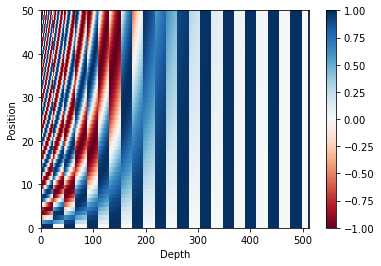

In [19]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

In [20]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [21]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [22]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [23]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [25]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [26]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [27]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [28]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [29]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

In [30]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [31]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

In [32]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [33]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

### Encoder layer

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [35]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [37]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

In [38]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [39]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

In [40]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [41]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

In [42]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [43]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [44]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = input_tokenizer.vocab_size + 2
target_vocab_size = target_tokenizer.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [46]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

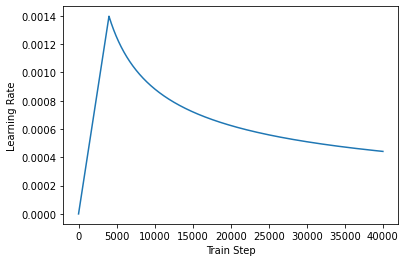

In [47]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [48]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [49]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [51]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [52]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [53]:
checkpoint_path = "./checkpoints/train/Stable_100EPOCHS_Char"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [54]:
EPOCHS = 100

In [55]:
run_id = f"StableData_{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{EPOCHS}EPOCHS_{YueChar}YueChar"
log_dir = os.path.join(os.path.join(os.getcwd(), 'log'), run_id)
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

In [56]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [57]:
summary_writer = tf.summary.create_file_writer(log_dir)
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  # Save output to TensorBoard
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.1301 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.0559 Accuracy 0.0105
Epoch 1 Batch 100 Loss 7.9245 Accuracy 0.0237
Epoch 1 Loss 7.9100 Accuracy 0.0243
Time taken for 1 epoch: 104.78104281425476 secs

Epoch 2 Batch 0 Loss 7.6417 Accuracy 0.0526
Epoch 2 Batch 50 Loss 7.5135 Accuracy 0.0373
Epoch 2 Batch 100 Loss 7.3531 Accuracy 0.0372
Epoch 2 Loss 7.3334 Accuracy 0.0367
Time taken for 1 epoch: 87.52825927734375 secs

Epoch 3 Batch 0 Loss 6.9802 Accuracy 0.0476
Epoch 3 Batch 50 Loss 6.7944 Accuracy 0.0372
Epoch 3 Batch 100 Loss 6.6238 Accuracy 0.0368
Epoch 3 Loss 6.6062 Accuracy 0.0365
Time taken for 1 epoch: 80.39754343032837 secs

Epoch 4 Batch 0 Loss 6.2123 Accuracy 0.0476
Epoch 4 Batch 50 Loss 6.1936 Accuracy 0.0377
Epoch 4 Batch 100 Loss 6.1233 Accuracy 0.0392
Epoch 4 Loss 6.1154 Accuracy 0.0395
Time taken for 1 epoch: 87.48443126678467 secs

Epoch 5 Batch 0 Loss 5.9513 Accuracy 0.0594
Epoch 5 Batch 50 Loss 5.9787 Accuracy 0.0489
Epoch 5 Batch 100 Loss 5.9255 Accu

Epoch 36 Batch 0 Loss 1.5432 Accuracy 0.2871
Epoch 36 Batch 50 Loss 1.5393 Accuracy 0.2440
Epoch 36 Batch 100 Loss 1.5161 Accuracy 0.2428
Epoch 36 Loss 1.5114 Accuracy 0.2418
Time taken for 1 epoch: 99.04148983955383 secs

Epoch 37 Batch 0 Loss 1.2923 Accuracy 0.3952
Epoch 37 Batch 50 Loss 1.4702 Accuracy 0.2549
Epoch 37 Batch 100 Loss 1.4452 Accuracy 0.2537
Epoch 37 Loss 1.4432 Accuracy 0.2522
Time taken for 1 epoch: 87.00960540771484 secs

Epoch 38 Batch 0 Loss 1.4401 Accuracy 0.3132
Epoch 38 Batch 50 Loss 1.4284 Accuracy 0.2613
Epoch 38 Batch 100 Loss 1.3989 Accuracy 0.2517
Epoch 38 Loss 1.3969 Accuracy 0.2518
Time taken for 1 epoch: 85.70109367370605 secs

Epoch 39 Batch 0 Loss 1.3634 Accuracy 0.1943
Epoch 39 Batch 50 Loss 1.3498 Accuracy 0.2637
Epoch 39 Batch 100 Loss 1.3256 Accuracy 0.2589
Epoch 39 Loss 1.3223 Accuracy 0.2596
Time taken for 1 epoch: 86.75124907493591 secs

Epoch 40 Batch 0 Loss 1.3242 Accuracy 0.3222
Epoch 40 Batch 50 Loss 1.2681 Accuracy 0.2740
Epoch 40 Batch 10

Saving checkpoint for epoch 70 at ./checkpoints/train/Stable_100EPOCHS_Char\ckpt-14
Epoch 70 Loss 0.3907 Accuracy 0.3512
Time taken for 1 epoch: 83.56759643554688 secs

Epoch 71 Batch 0 Loss 0.3454 Accuracy 0.4568
Epoch 71 Batch 50 Loss 0.3702 Accuracy 0.3639
Epoch 71 Batch 100 Loss 0.3698 Accuracy 0.3604
Epoch 71 Loss 0.3693 Accuracy 0.3581
Time taken for 1 epoch: 75.60541462898254 secs

Epoch 72 Batch 0 Loss 0.3551 Accuracy 0.4391
Epoch 72 Batch 50 Loss 0.3675 Accuracy 0.3501
Epoch 72 Batch 100 Loss 0.3646 Accuracy 0.3584
Epoch 72 Loss 0.3639 Accuracy 0.3572
Time taken for 1 epoch: 73.89977931976318 secs

Epoch 73 Batch 0 Loss 0.3559 Accuracy 0.4449
Epoch 73 Batch 50 Loss 0.3576 Accuracy 0.3605
Epoch 73 Batch 100 Loss 0.3572 Accuracy 0.3602
Epoch 73 Loss 0.3577 Accuracy 0.3574
Time taken for 1 epoch: 72.67850589752197 secs

Epoch 74 Batch 0 Loss 0.3237 Accuracy 0.4412
Epoch 74 Batch 50 Loss 0.3567 Accuracy 0.3597
Epoch 74 Batch 100 Loss 0.3498 Accuracy 0.3560
Epoch 74 Loss 0.3499 Acc

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the `input_tokenizer`. Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == target_tokenizer.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [58]:
def evaluate(inp_sentence):
  start_token = [input_tokenizer.vocab_size]
  end_token = [input_tokenizer.vocab_size + 1]
  
  inp_sentence = start_token + input_tokenizer.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  decoder_input = [target_tokenizer.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == target_tokenizer.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [147]:
# Chinese font in matplotlib
from matplotlib.font_manager import FontProperties
import wget
# !wget -qO taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
# !mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.6/dist-packages/matplotlib//mpl-data/fonts/ttf
# chinese = FontProperties(fname=r'/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')
if not os.path.isfile('taipei_sans_tc_beta.ttf'):
    wget.download('https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download', 'taipei_sans_tc_beta.ttf')
chinese = FontProperties(fname=r'taipei_sans_tc_beta.ttf')

In [148]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = input_tokenizer.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    # show Chinese character
    fontdict = {"fontproperties": chinese}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[input_tokenizer.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([target_tokenizer.decode([i]) for i in result 
                        if i < target_tokenizer.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [60]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = target_tokenizer.decode([i for i in result 
                                            if i < target_tokenizer.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

sometimes stronger
有 時 好 勇 敢 

Input: sometimes stronger
Predicted translation: 係同其他家高段作為我哋分離


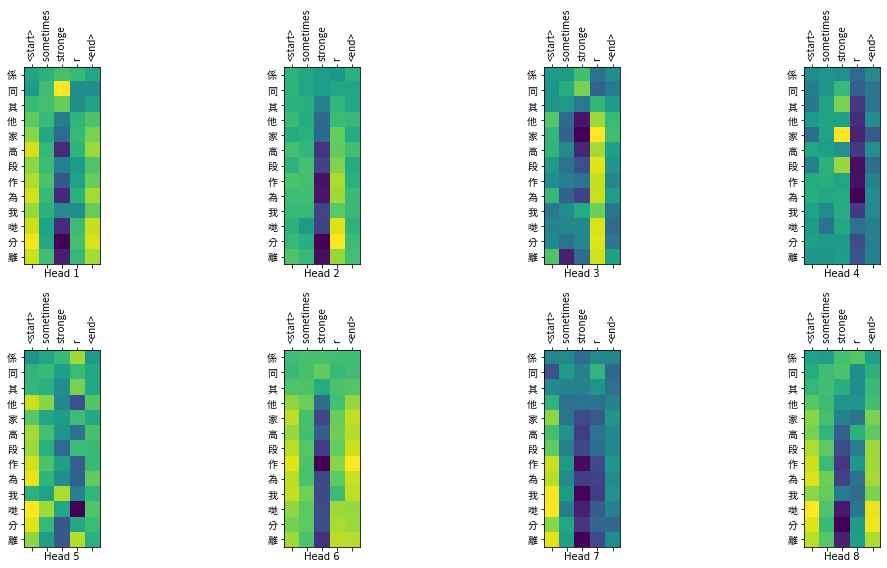

In [176]:
row = df_test.sample()
inp = row[inp_lang].values[0]
tar = row[tar_lang].values[0]
print(inp)
print(tar, '\n')

translate(inp, plot='decoder_layer4_block2')

In [62]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1790592   
_________________________________________________________________
decoder_2 (Decoder)          multiple                  1489024   
_________________________________________________________________
dense_151 (Dense)            multiple                  434085    
Total params: 3,713,701
Trainable params: 3,713,701
Non-trainable params: 0
_________________________________________________________________


In [63]:
def translateTest(sentence):
  result, attention_weights = evaluate(sentence)
  
  sentence = input_tokenizer.encode(sentence)
  sentence = ' '.join([input_tokenizer.decode([i]) for i in sentence])
  predicted_sentence = target_tokenizer.decode([i for i in result 
                                            if i < target_tokenizer.vocab_size])  

#   print('Input: {}'.format(sentence))
#   print('Predicted translation: {}'.format(predicted_sentence))
  return sentence, predicted_sentence

In [177]:
TotalTime = time.time()
start = time.time()

ori = []
ref = []
can = []
num_test = 0

for index, row in df_test.iterrows():
    inp = row[inp_lang]
    tar = row[tar_lang]
    num_test += 1
    o, pre = translateTest(inp)
    ori.append(o)
    ref.append(tar)
    if YueChar:
        can.append(spliteKeyWord(pre))
    else:
        can.append(pre)
    if num_test % 50 == 0:
        print(f'Progress: {num_test} / {len(df_test)} in {time.time()-start} s')
        start = time.time()
        
print(f'\nToTal: {num_test} / {len(df_test)} in {time.time()-TotalTime} s')

Progress: 50 / 1696 in 40.48380923271179 s
Progress: 100 / 1696 in 40.220704555511475 s
Progress: 150 / 1696 in 43.20770812034607 s
Progress: 200 / 1696 in 45.007137060165405 s
Progress: 250 / 1696 in 37.27789783477783 s
Progress: 300 / 1696 in 42.222140073776245 s
Progress: 350 / 1696 in 45.22392392158508 s
Progress: 400 / 1696 in 42.280128955841064 s
Progress: 450 / 1696 in 46.22187280654907 s
Progress: 500 / 1696 in 42.567705392837524 s
Progress: 550 / 1696 in 41.71821618080139 s
Progress: 600 / 1696 in 40.554606914520264 s
Progress: 650 / 1696 in 38.660369873046875 s
Progress: 700 / 1696 in 43.632325887680054 s
Progress: 750 / 1696 in 40.4176344871521 s
Progress: 800 / 1696 in 42.83441090583801 s
Progress: 850 / 1696 in 46.236815452575684 s
Progress: 900 / 1696 in 39.60803532600403 s
Progress: 950 / 1696 in 43.31564807891846 s
Progress: 1000 / 1696 in 44.356711626052856 s
Progress: 1050 / 1696 in 41.441861391067505 s
Progress: 1100 / 1696 in 36.51431751251221 s
Progress: 1150 / 169

In [180]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

import random
ran = random.randint(1, len(ref))
print(ori[ran])
print(ref[ran])
print(can[ran])

smoothie = SmoothingFunction().method4
print('BLEU:', sentence_bleu(ref[ran], can[ran], smoothing_function=smoothie)*100)

But  everyone  knows  we  re  together
我 點 頭 先 真 係 要 同 一 齊 啦
但 我 哋 知 道 大 隻 大 man
BLEU: 1.0377133938315695e-229


In [181]:
# Sentence-based and average score
score = 0
for i in range(len(ref)):
    r = [ref[i].split()]
    c = can[i].split()
    score += sentence_bleu(r, c, smoothing_function=smoothie)*100
print('BLEU-s:', score/len(ref))

# Corpus based, summing all nominator and denominator before division
r = [[r.split()] for r in ref]
c = [c.split() for c in can]
score = corpus_bleu(r, c, smoothing_function=smoothie)*100
print('BLEU-c:', score)

BLEU-s: 1.659785269087643
BLEU-c: 3.749065151206458
